In [28]:
# ==================================================================================================================
# ===========================================> Instalación librerías <==============================================
# ==================================================================================================================

#%pip install pandas    # NO HACE FALTA INSTALAR
#%pip install numpy     # NO HACE FALTA INSTALAR
#%pip install pickle    # NO HACE FALTA INSTALAR
#%pip install sklearn   # NO HACE FALTA INSTALAR

#%pip install scikit-learn          # DESCOMENTAR LA PRIMERA VEZ
#%pip install category_encoders     # DESCOMENTAR LA PRIMERA VEZ
#%pip install lightgbm              # DESCOMENTAR LA PRIMERA VEZ
#%pip install matplotlib            # DESCOMENTAR LA PRIMERA VEZ
#%pip install seaborn               # DESCOMENTAR LA PRIMERA VEZ



In [29]:
# ==================================================================================================================
# ===========================================> Carga librerías <====================================================
# ==================================================================================================================

import pandas as pd
import numpy as np
import pickle

# Transformación de datos
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
import category_encoders as ce

# Modelos
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb

# Seleccion de variables y tuning de hiperparámetros
from sklearn.feature_selection import RFECV, RFE
from sklearn.model_selection import train_test_split, RandomizedSearchCV

# Métricas para evaluar un modelo de clasificación
from sklearn.metrics import classification_report, precision_recall_curve, auc, roc_curve, roc_auc_score, average_precision_score, confusion_matrix

# Librerías para visualización de resultados
import matplotlib.pyplot as plt
import seaborn as sns

# Tratamiento de datos
# ------------------------------------------------------------------------------
import numpy as np
import pandas as pd
import statsmodels.api as sm

# Gráficos
# ------------------------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocesado y modelado
# ------------------------------------------------------------------------------
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_graphviz, export_text
from sklearn.model_selection import GridSearchCV
#from sklearn.metrics import accuracy_score, confusion_matrix, auc, plot_roc_curve, roc_curve, classification_report
from sklearn.metrics import accuracy_score, confusion_matrix, auc, RocCurveDisplay , roc_curve, classification_report

# Para que no se corten el listado de filas y columnas al ejecutar instrucciones
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [30]:
# ==================================================================================================================
# ===========================================> Carga Datos <========================================================
# ==================================================================================================================


datos = pd.read_csv('../data/train.csv', low_memory=False).sample(10000)
#datos = pd.read_csv('../data/train_dev.csv', low_memory=False)         # 20.000 filas del fichero train para trabajar en desarrollo

# =====================> EDA

In [31]:
# ==================================================================================================================
# ===========================================> Exploración número de columnas <=====================================
# ==================================================================================================================

len(datos.columns)

83

In [32]:
# ==================================================================================================================
# ===========================================> Exploración estadisticas basicas col numericas <=====================
# ==================================================================================================================

datos.describe()

,IsBeta,RtpStateBitfield,IsSxsPassiveMode,DefaultBrowsersIdentifier,AVProductStatesIdentifier,AVProductsInstalled,AVProductsEnabled,HasTpm,CountryIdentifier,CityIdentifier,OrganizationIdentifier,GeoNameIdentifier,LocaleEnglishNameIdentifier,OsBuild,OsSuite,IsProtected,AutoSampleOptIn,SMode,IeVerIdentifier,Firewall,UacLuaenable,Census_OEMNameIdentifier,Census_OEMModelIdentifier,Census_ProcessorCoreCount,Census_ProcessorManufacturerIdentifier,Census_ProcessorModelIdentifier,Census_PrimaryDiskTotalCapacity,Census_SystemVolumeTotalCapacity,Census_HasOpticalDiskDrive,Census_TotalPhysicalRAM,Census_InternalPrimaryDiagonalDisplaySizeInInches,Census_InternalPrimaryDisplayResolutionHorizontal,Census_InternalPrimaryDisplayResolutionVertical,Census_InternalBatteryNumberOfCharges,Census_OSBuildNumber,Census_OSBuildRevision,Census_OSInstallLanguageIdentifier,Census_OSUILocaleIdentifier,Census_IsPortableOperatingSystem,Census_IsFlightingInternal,Census_IsFlightsDisabled,Census_ThresholdOptIn,Census_FirmwareManufacturerIdentifier,Census_FirmwareVersionIdentifier,Census_IsSecureBootEnabled,Census_IsWIMBootEnabled,Census_IsVirtualDevice,Census_IsTouchEnabled,Census_IsPenCapable,Census_IsAlwaysOnAlwaysConnectedCapable,Wdft_IsGamer,Wdft_RegionIdentifier,HasDetections
count,10000.0,9955.000000,10000.000000,514.000000,9962.000000,9962.000000,9962.000000,10000.000000,10000.00000,9616.000000,6928.000000,10000.000000,10000.000000,10000.000000,10000.000000,9962.000000,10000.0,9373.000000,9936.000000,9895.000000,9992.000000,9878.000000,9872.000000,9947.000000,9947.000000,9947.000000,9.938000e+03,9.938000e+03,10000.000000,9903.00000,9940.000000,9940.000000,9940.000000,9.654000e+03,10000.000000,10000.000000,9929.000000,10000.00000,10000.000000,1643.0,9812.0,3534.0,9785.000000,9818.000000,10000.000000,3545.0,9985.000000,10000.000000,10000.000000,9920.000000,9662.000000,9662.000000,10000.000
mean,0.0,6.830638,0.018600,1726.970817,47813.957539,1.328047,1.021783,0.987600,108.07360,82325.148087,24.905889,169.724100,123.023900,15723.939200,575.238400,0.941377,0.0,0.000533,126.489936,0.979384,0.993195,2228.620571,239744.645361,3.976375,4.524882,2362.724540,5.098637e+05,3.743543e+05,0.073700,6151.76805,16.676901,1550.364286,899.097887,1.134025e+09,15831.476200,959.245100,14.701078,60.90540,0.000600,0.0,0.0,0.0,403.092999,33219.392239,0.488300,0.0,0.007211,0.126900,0.036900,0.059173,0.286587,7.845788,0.505
std,0.0,1.073100,0.135114,1007.164701,14156.295069,0.522359,0.175920,0.110668,63.21078,48985.527796,5.501166,89.811662,69.617824,2177.324662,248.088437,0.234929,0.0,0.023092,42.502931,0.142104,0.082218,1326.522983,71925.153701,2.108972,1.294025,841.828355,3.505280e+05,3.203527e+05,0.261295,5051.28587,5.843683,369.302910,215.856181,1.893398e+09,1956.319741,2912.465146,10.268106,45.35013,0.024489,0.0,0.0,0.0,222.527720,21245.490424,0.499888,0.0,0.084614,0.332878,0.188526,0.235961,0.452190,4.576306,0.500
min,0.0,0.000000,0.000000,132.000000,522.000000,1.000000,0.000000,0.000000,1.00000,30.000000,2.000000,1.000000,2.000000,7600.000000,16.000000,0.000000,0.0,0.000000,41.000000,0.000000,0.000000,176.000000,232.000000,1.000000,1.000000,19.000000,1.024000e+04,9.738000e+03,0.000000,503.00000,6.900000,600.000000,400.000000,0.000000e+00,10240.000000,0.000000,1.000000,5.00000,0.000000,0.0,0.0,0.0,93.000000,64.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000
25%,0.0,7.000000,0.000000,788.000000,49480.000000,1.000000,1.000000,1.000000,50.00000,37376.000000,18.000000,89.000000,75.000000,15063.000000,256.000000,1.000000,0.0,0.000000,111.000000,1.000000,1.000000,1443.000000,189699.500000,2.000000,5.000000,1998.000000,2.384750e+05,1.206390e+05,0.000000,4096.00000,13.900000,1366.000000,768.000000,0.000000e+00,15063.000000,165.000000,8.000000,31.00000,0.000000,0.0,0.0,0.0,142.000000,12968.250000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000
50%,0.0,7.000000,0.000000,1727.000000,53447.000000,1.000000,1.000000,1.000000,97.000

In [33]:
# ==================================================================================================================
# ===========================================> Exploración estadisticas basicas col objectos <=====================
# ==================================================================================================================

datos.describe(include=object)

,MachineIdentifier,ProductName,EngineVersion,AppVersion,AvSigVersion,Platform,Processor,OsVer,OsPlatformSubRelease,OsBuildLab,SkuEdition,PuaMode,SmartScreen,Census_MDC2FormFactor,Census_DeviceFamily,Census_ProcessorClass,Census_PrimaryDiskTypeName,Census_ChassisTypeName,Census_PowerPlatformRoleName,Census_InternalBatteryType,Census_OSVersion,Census_OSArchitecture,Census_OSBranch,Census_OSEdition,Census_OSSkuName,Census_OSInstallTypeName,Census_OSWUAutoUpdateOptionsName,Census_GenuineStateName,Census_ActivationChannel,Census_FlightRing
count,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000,4,6347,10000,10000,33,9980,10000,10000,2833,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000
unique,10000,2,32,57,1663,4,2,6,9,211,8,1,8,11,2,3,4,23,8,15,188,2,13,16,15,9,6,4,6,7
top,c6053a022c759f31ca2cc2145e8fffff,win8defender,1.1.15200.1,4.18.1807.18075,1.263.48.0,windows10,x64,10.0.0.0,rs4,17134.1.amd64fre.rs4_release.180410-1804,Home,on,RequireAdmin,Notebook,Windows.Desktop,mid,HDD,Notebook,Mobile,lion,10.0.17134.228,amd64,rs4_release,Core,CORE,UUPUpgrade,FullAuto,IS_GENUINE,Retail,Retail
freq,1,9889,4390,5760,117,9667,9088,9678,4334,4062,6180,4,4716,6396,9988,16,6419,5887,6894,2208,1523,9089,4447,3907,3906,2833,4328,8808,5306,9357


In [34]:
# ==================================================================================================================
# ===========================================> Exploración 20 primeras filas <======================================
# ==================================================================================================================

datos.head(20)

,MachineIdentifier,ProductName,EngineVersion,AppVersion,AvSigVersion,IsBeta,RtpStateBitfield,IsSxsPassiveMode,DefaultBrowsersIdentifier,AVProductStatesIdentifier,AVProductsInstalled,AVProductsEnabled,HasTpm,CountryIdentifier,CityIdentifier,OrganizationIdentifier,GeoNameIdentifier,LocaleEnglishNameIdentifier,Platform,Processor,OsVer,OsBuild,OsSuite,OsPlatformSubRelease,OsBuildLab,SkuEdition,IsProtected,AutoSampleOptIn,PuaMode,SMode,IeVerIdentifier,SmartScreen,Firewall,UacLuaenable,Census_MDC2FormFactor,Census_DeviceFamily,Census_OEMNameIdentifier,Census_OEMModelIdentifier,Census_ProcessorCoreCount,Census_ProcessorManufacturerIdentifier,Census_ProcessorModelIdentifier,Census_ProcessorClass,Census_PrimaryDiskTotalCapacity,Census_PrimaryDiskTypeName,Census_SystemVolumeTotalCapacity,Census_HasOpticalDiskDrive,Census_TotalPhysicalRAM,Census_ChassisTypeName,Census_InternalPrimaryDiagonalDisplaySizeInInches,Census_InternalPrimaryDisplayResolutionHorizontal,Census_InternalPrimaryDisplayResolutionVertical,Census_PowerPlatformRoleName,Census_InternalBatteryType,Census_InternalBatteryNumberOfCharges,Census_OSVersion,Census_OSArchitecture,Census_OSBranch,Census_OSBuildNumber,Census_OSBuildRevision,Census_OSEdition,Census_OSSkuName,Census_OSInstallTypeName,Census_OSInstallLanguageIdentifier,Census_OSUILocaleIdentifier,Census_OSWUAutoUpdateOptionsName,Census_IsPortableOperatingSystem,Census_GenuineStateName,Census_ActivationChannel,Census_IsFlightingInternal,Census_IsFlightsDisabled,Census_FlightRing,Census_ThresholdOptIn,Census_FirmwareManufacturerIdentifier,Census_FirmwareVersionIdentifier,Census_IsSecureBootEnabled,Census_IsWIMBootEnabled,Census_IsVirtualDevice,Census_IsTouchEnabled,Census_IsPenCapable,Census_IsAlwaysOnAlwaysConnectedCapable,Wdft_IsGamer,Wdft_RegionIdentifier,HasDetections
708241,c6053a022c759f31ca2cc2145e8fffff,win8defender,1.1.15100.1,4.18.1806.18062,1.273.1311.0,0,7.0,0,NaN,53447.0,1.0,1.0,1,142,141994.0,NaN,157.0,68,windows10,x64,10.0.0.0,17134,768,rs4,17134.1.amd64fre.rs4_release.180410-1804,Home,1.0,0,NaN,0.0,137.0,RequireAdmin,1.0,1.0,Notebook,Windows.Desktop,585.0,189533.0,2.0,5.0,2097.0,NaN,476940.0,HDD,217647.0,0,4096.0,Notebook,13.9,1366.0,768.0,Mobile,NaN,0.000000e+00,10.0.17134.112,amd64,rs4_release,17134,112,CoreSingleLanguage,CORE_SINGLELANGUAGE,UUPUpgrade,8.0,31,UNKNOWN,0,IS_GENUINE,OEM:DM,NaN,0.0,Retail,NaN,556.0,63155.0,1,NaN,0.0,0,0,0.0,0.0,1.0,1
365389,3b41be27beda803c40853b1f41998657,win8defender,1.1.15200.1,4.9.10586.1106,1.275.1654.0,0,7.0,0,NaN,53447.0,1.0,1.0,1,151,70564.0,NaN,277.0,75,windows10,x64,10.0.0.0,10586,256,th2,10586.1176.amd64fre.th2_release_sec.170913-1848,Pro,1.0,0,NaN,0.0,74.0,RequireAdmin,1.0,1.0,Notebook,Windows.Desktop,1443.0,260878.0,4.0,5.0,2920.0,NaN,244198.0,SSD,243688.0,0,8192.0,Laptop,12.5,1920.0,1080.0,Mobile,lip,0.000000e+00,10.0.10586.1176,amd64,th2_release_sec,10586,1176,Professional,PROFESSIONAL,IBSClean,8.0,31,UNKNOWN,0,IS_GENUINE,Volume:GVLK,0.0,0.0,Retail,0.0,355.0,20246.0,0,0.0,0.0,1,0,0.0,0.0,1.0,0
152362,d6d6ba49368f972174f1ca6ca1ae004e,win8defender,1.1.15100.1,4.18.1807.18075,1.273.798.0,0,7.0,0,NaN,53447.0,1.0,1.0,1,178,136271.0,27.0,230.0,71,windows10,x64,10.0.0.0,17134,256,rs4,17134.1.amd64fre.rs4_release.180410-1804,Pro,1.0,0,NaN,0.0,137.0,NaN,1.0,1.0,Notebook,Windows.Desktop,1443.0,256746.0,4.0,5.0,2666.0,NaN,244198.0,SSD,242747.0,0,16384.0,Notebook,15.5,1920.0,1080.0,Mobile,NaN,0.000000e+00,10.0.17134.191,amd64,rs4_release,17134,191,Professional,PROFESSIONAL,Reset,8.0,31,FullAuto,0,IS_GENUINE,Retail,NaN,0.0,Retail,NaN,355.0,7142.0,0,NaN,0.0,0,0,0.0,0.0,1.0,0
473338,cf17278e4e7852e6fd62b9aea700e2f9,win8defender,1.1.15200.1,4.13.17134.1,1.275.1503.0,0,7.0,0,NaN,53447.0,1.0,1.0,1,107,20941.0,27.0,138.0,134,windows10,x64,10.0.0.0,17134,256,rs4,17134.1.amd64fre.rs4_release.180410-1804,Pro,1.0,0,NaN,0.0,137.0,NaN,1.0,1.0,Desktop,Windows.Desktop,4589.0,313586.0,4.0,1.0,1155.0,NaN,122104.0,SSD,121553.0,0,4096.0,Desktop,22.0,1680.0,1050.0,Desktop,NaN,4.294967e+09,1

In [35]:
# ==================================================================================================================
# ===========================================> Exploración tipos <==================================================
# ==================================================================================================================






<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 708241 to 555583
Data columns (total 83 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   MachineIdentifier                                  10000 non-null  object 
 1   ProductName                                        10000 non-null  object 
 2   EngineVersion                                      10000 non-null  object 
 3   AppVersion                                         10000 non-null  object 
 4   AvSigVersion                                       10000 non-null  object 
 5   IsBeta                                             10000 non-null  int64  
 6   RtpStateBitfield                                   9955 non-null   float64
 7   IsSxsPassiveMode                                   10000 non-null  int64  
 8   DefaultBrowsersIdentifier                          514 non-null    float64
 9   AVPro

In [36]:
# ==================================================================================================================
# ===========================================> Exploración nulos <==================================================
# ==================================================================================================================

datos.isna().sum().sort_values(ascending=False)

PuaMode                                              9996
Census_ProcessorClass                                9967
DefaultBrowsersIdentifier                            9486
Census_IsFlightingInternal                           8357
Census_InternalBatteryType                           7167
Census_ThresholdOptIn                                6466
Census_IsWIMBootEnabled                              6455
SmartScreen                                          3653
OrganizationIdentifier                               3072
SMode                                                 627
CityIdentifier                                        384
Census_InternalBatteryNumberOfCharges                 346
Wdft_RegionIdentifier                                 338
Wdft_IsGamer                                          338
Census_FirmwareManufacturerIdentifier                 215
Census_IsFlightsDisabled                              188
Census_FirmwareVersionIdentifier                      182
Census_OEMMode

In [37]:
# ==================================================================================================================
# ===========================================> Exploración valores y estadísticas <=================================
# ==================================================================================================================

stats_1 = []
# Unique Values         col 
# Unique Values         datos[col].nunique() 
# Unique Values %       (datos[col].nunique() / datos[col].count()) * 100
# Missing Values %      datos[col].isnull().sum() * 100 / datos.shape[0]
# Biggest Category %    datos[col].value_counts(normalize=True, dropna=False).values[0] * 100
# Type                  datos[col].dtype

for col in datos.columns:
    stats_1.append((col, datos[col].nunique(), (datos[col].nunique() / datos[col].count()) * 100, datos[col].isnull().sum() * 100 / datos.shape[0], datos[col].value_counts(normalize=True, dropna=False).values[0] * 100, datos[col].dtype))
    
stats = pd.DataFrame(stats_1, columns=['Feature', 'Unique Values', 'Unique Values %', 'Missing Values %', 'Biggest Category %', 'Type'])
stats.sort_values('Biggest Category %', ascending=False)

,Feature,Unique Values,Unique Values %,Missing Values %,Biggest Category %,Type
5,IsBeta,1,0.010000,0.00,100.00,int64
27,AutoSampleOptIn,1,0.010000,0.00,100.00,int64
28,PuaMode,1,25.000000,99.96,99.96,object
65,Census_IsPortableOperatingSystem,2,0.020000,0.00,99.94,int64
35,Census_DeviceFamily,2,0.020000,0.00,99.88,object
41,Census_ProcessorClass,3,9.090909,99.67,99.67,object
33,UacLuaenable,2,0.020016,0.08,99.24,float64
76,Census_IsVirtualDevice,2,0.020030,0.15,99.13,float64
1,ProductName,2,0.020000,0.00,98.89,object
12,HasTpm,2,0.020000,0.00,98.76,int64


In [38]:
# ==================================================================================================================
# ===========================================> Eliminar valores nulos <=============================================
# ==================================================================================================================

drop_cols_min_nulls = 0.7
drop_cols_nulls = []


for col in datos.columns:
    if datos[col].isna().sum() / len(datos) >= drop_cols_min_nulls:
        drop_cols_nulls.append(col)

datos.drop(columns=drop_cols_nulls, inplace=True)

drop_cols_nulls

['DefaultBrowsersIdentifier',
 'PuaMode',
 'Census_ProcessorClass',
 'Census_InternalBatteryType',
 'Census_IsFlightingInternal']

In [39]:
# ==================================================================================================================
# ===========================================> Eliminar valores identificadores <===================================
# ==================================================================================================================

drop_cols_id = []

datos.drop(columns=drop_cols_id, inplace=True)

drop_cols_id

[]

In [40]:
# ==================================================================================================================
# ===========================================> Separar datos por tipos categoricas <================================
# ==================================================================================================================

cat_cols = datos.select_dtypes(include=['object', 'category']).columns.to_list()

for col in cat_cols:
    datos[col] = datos[col].astype("category")

cat_cols

['MachineIdentifier',
 'ProductName',
 'EngineVersion',
 'AppVersion',
 'AvSigVersion',
 'Platform',
 'Processor',
 'OsVer',
 'OsPlatformSubRelease',
 'OsBuildLab',
 'SkuEdition',
 'SmartScreen',
 'Census_MDC2FormFactor',
 'Census_DeviceFamily',
 'Census_PrimaryDiskTypeName',
 'Census_ChassisTypeName',
 'Census_PowerPlatformRoleName',
 'Census_OSVersion',
 'Census_OSArchitecture',
 'Census_OSBranch',
 'Census_OSEdition',
 'Census_OSSkuName',
 'Census_OSInstallTypeName',
 'Census_OSWUAutoUpdateOptionsName',
 'Census_GenuineStateName',
 'Census_ActivationChannel',
 'Census_FlightRing']

In [41]:
# ==================================================================================================================
# ===========================================> Separar datos por tipos numericas <==================================
# ==================================================================================================================

numeric_cols = datos.select_dtypes(include=['int16', 'int32', 'int64', 'float16', 'float32', 'float64']).columns.to_list()
numeric_cols.remove('HasDetections') # Posibles labels HasDetections or IsProtected

numeric_cols

['IsBeta',
 'RtpStateBitfield',
 'IsSxsPassiveMode',
 'AVProductStatesIdentifier',
 'AVProductsInstalled',
 'AVProductsEnabled',
 'HasTpm',
 'CountryIdentifier',
 'CityIdentifier',
 'OrganizationIdentifier',
 'GeoNameIdentifier',
 'LocaleEnglishNameIdentifier',
 'OsBuild',
 'OsSuite',
 'IsProtected',
 'AutoSampleOptIn',
 'SMode',
 'IeVerIdentifier',
 'Firewall',
 'UacLuaenable',
 'Census_OEMNameIdentifier',
 'Census_OEMModelIdentifier',
 'Census_ProcessorCoreCount',
 'Census_ProcessorManufacturerIdentifier',
 'Census_ProcessorModelIdentifier',
 'Census_PrimaryDiskTotalCapacity',
 'Census_SystemVolumeTotalCapacity',
 'Census_HasOpticalDiskDrive',
 'Census_TotalPhysicalRAM',
 'Census_InternalPrimaryDiagonalDisplaySizeInInches',
 'Census_InternalPrimaryDisplayResolutionHorizontal',
 'Census_InternalPrimaryDisplayResolutionVertical',
 'Census_InternalBatteryNumberOfCharges',
 'Census_OSBuildNumber',
 'Census_OSBuildRevision',
 'Census_OSInstallLanguageIdentifier',
 'Census_OSUILocaleIdenti

In [42]:
# ==================================================================================================================
# ===========================================> Separar datos numericas a categoricas <==============================
# ==================================================================================================================

numeric_cols_cat_min = 1
numeric_cols_cat = []

for col in numeric_cols:
    if (datos[col].nunique() / datos[col].count()) * 100 >= numeric_cols_cat_min:
        numeric_cols_cat.append(col) 

for col in numeric_cols_cat:
    cat_cols.append(col)

for col in numeric_cols_cat:
    datos[col] = datos[col].astype("category")

for col in numeric_cols_cat:
    numeric_cols.remove(col)
    
numeric_cols_cat

['AVProductStatesIdentifier',
 'CountryIdentifier',
 'CityIdentifier',
 'GeoNameIdentifier',
 'LocaleEnglishNameIdentifier',
 'Census_OEMNameIdentifier',
 'Census_OEMModelIdentifier',
 'Census_ProcessorModelIdentifier',
 'Census_PrimaryDiskTotalCapacity',
 'Census_SystemVolumeTotalCapacity',
 'Census_InternalPrimaryDiagonalDisplaySizeInInches',
 'Census_InternalBatteryNumberOfCharges',
 'Census_OSBuildRevision',
 'Census_FirmwareVersionIdentifier']

In [43]:
# ==================================================================================================================
# ===========================================> Imputar nulos para tipos categoricas <===============================
# ==================================================================================================================

imp_cat = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
datos[cat_cols] = imp_cat.fit_transform(datos[cat_cols])

datos.isnull().sum()

MachineIdentifier                                       0
ProductName                                             0
EngineVersion                                           0
AppVersion                                              0
AvSigVersion                                            0
IsBeta                                                  0
RtpStateBitfield                                       45
IsSxsPassiveMode                                        0
AVProductStatesIdentifier                               0
AVProductsInstalled                                    38
AVProductsEnabled                                      38
HasTpm                                                  0
CountryIdentifier                                       0
CityIdentifier                                          0
OrganizationIdentifier                               3072
GeoNameIdentifier                                       0
LocaleEnglishNameIdentifier                             0
Platform      

In [44]:
# ==================================================================================================================
# ===========================================> Imputar nulos para tipos numericas <=================================
# ==================================================================================================================

imp_num = SimpleImputer(missing_values=np.nan, strategy='mean')
datos[numeric_cols] = imp_num.fit_transform(datos[numeric_cols])

datos.isnull().sum()

MachineIdentifier                                    0
ProductName                                          0
EngineVersion                                        0
AppVersion                                           0
AvSigVersion                                         0
IsBeta                                               0
RtpStateBitfield                                     0
IsSxsPassiveMode                                     0
AVProductStatesIdentifier                            0
AVProductsInstalled                                  0
AVProductsEnabled                                    0
HasTpm                                               0
CountryIdentifier                                    0
CityIdentifier                                       0
OrganizationIdentifier                               0
GeoNameIdentifier                                    0
LocaleEnglishNameIdentifier                          0
Platform                                             0
Processor 

In [45]:
# ==================================================================================================================
# ===========================================> Calculamos el rango intercuartílico <================================
# ==================================================================================================================

Q1 = datos[numeric_cols].quantile(0.25)
Q3 = datos[numeric_cols].quantile(0.75)
IQR = Q3 - Q1

((datos[numeric_cols] < (Q1 - 1.5 * IQR)) | (datos[numeric_cols] > (Q3 + 1.5 * IQR))).sum()

IsBeta                                                  0
RtpStateBitfield                                      338
IsSxsPassiveMode                                      186
AVProductsInstalled                                    11
AVProductsEnabled                                     320
HasTpm                                                124
OrganizationIdentifier                               2139
OsBuild                                              1064
OsSuite                                                 0
IsProtected                                           622
AutoSampleOptIn                                         0
SMode                                                 632
IeVerIdentifier                                       678
Firewall                                              309
UacLuaenable                                           76
Census_ProcessorCoreCount                            1099
Census_ProcessorManufacturerIdentifier               1235
Census_HasOpti

In [46]:
# ==================================================================================================================
# ===========================================> Tratamiento de valores atípicos <====================================
# ==================================================================================================================

datos[numeric_cols] = datos[numeric_cols][~((datos[numeric_cols] < (Q1 - 1.5 * IQR)) |(datos[numeric_cols] > (Q3 + 1.5 * IQR))).any(axis=1)]

((datos[numeric_cols] < (Q1 - 1.5 * IQR)) | (datos[numeric_cols] > (Q3 + 1.5 * IQR))).sum()

IsBeta                                               0
RtpStateBitfield                                     0
IsSxsPassiveMode                                     0
AVProductsInstalled                                  0
AVProductsEnabled                                    0
HasTpm                                               0
OrganizationIdentifier                               0
OsBuild                                              0
OsSuite                                              0
IsProtected                                          0
AutoSampleOptIn                                      0
SMode                                                0
IeVerIdentifier                                      0
Firewall                                             0
UacLuaenable                                         0
Census_ProcessorCoreCount                            0
Census_ProcessorManufacturerIdentifier               0
Census_HasOpticalDiskDrive                           0
Census_Tot

In [47]:
# ==================================================================================================================
# ===========================================> Procesar mascaras y versiones 3 partes <=============================
# ==================================================================================================================

mask_cols_3 = []

for col in datos.columns:
    if datos[col].notnull().all() and datos[col].astype(str).apply(lambda x: x.count('.') == 2).all():
        mask_cols_3.append(c)

for col in mask_cols_3:
    datos[[col + "_1", col + "_2", col + "_3"]] = datos[col].str.split(".", expand=True)

for col in mask_cols_3:
    cat_cols.remove(col)
    cat_cols.append(col + "_1")
    cat_cols.append(col + "_2")
    cat_cols.append(col + "_3")

datos.drop(columns=mask_cols_3, inplace=True)

mask_cols_3

[]

In [48]:
# ==================================================================================================================
# ===========================================> Procesar mascaras y versiones 4 partes <=============================
# ==================================================================================================================

mask_cols_4 = []

for col in datos.columns:
    if datos[col].notnull().all() and datos[col].astype(str).apply(lambda x: x.count('.') == 3).all():
        mask_cols_4.append(col)

for col in mask_cols_4:
    datos[[col + "_1", col + "_2", col + "_3", col + "_4"]] = datos[col].str.split(".", expand=True)

for col in mask_cols_4:
    cat_cols.remove(col)
    cat_cols.append(col + "_1")
    cat_cols.append(col + "_2")
    cat_cols.append(col + "_3")
    cat_cols.append(col + "_4")

datos.drop(columns=mask_cols_4, inplace=True)

mask_cols_4

['EngineVersion', 'AppVersion', 'AvSigVersion', 'OsVer', 'Census_OSVersion']

In [49]:
# ==================================================================================================================
# ===========================================> Procesar mascaras y versiones 5 partes <=============================
# ==================================================================================================================

mask_cols_5 = []

for col in datos.columns:
    if datos[col].notnull().all() and datos[col].astype(str).apply(lambda x: x.count('.') == 4).all():
        mask_cols_5.append(col)

for col in mask_cols_5:
    datos[[col + "_1", col + "_2", col + "_3", col + "_4", col + "_5"]] = datos[col].str.split(".", expand=True)

for col in mask_cols_5:
    cat_cols.remove(col)
    cat_cols.append(col + "_1")
    cat_cols.append(col + "_2")
    cat_cols.append(col + "_3")
    cat_cols.append(col + "_4")
    cat_cols.append(col + "_5")

datos.drop(columns=mask_cols_5, inplace=True)

mask_cols_5

['OsBuildLab']

In [50]:
# ==================================================================================================================
# ===========================================> Procesar mascaras y versiones 6 partes <=============================
# ==================================================================================================================

mask_cols_6 = []

for c in datos.columns:
    if datos[c].notnull().all() and datos[c].astype(str).apply(lambda x: x.count('.') == 5).all():
        mask_cols_6.append(c)

for c in mask_cols_6:
    datos[[col + "_1", col + "_2", col + "_3", col + "_4", col + "_5", col + "_6"]] = datos[c].str.split(".", expand=True)

for col in mask_cols_6:
    cat_cols.remove(col)
    cat_cols.append(col + "_1")
    cat_cols.append(col + "_2")
    cat_cols.append(col + "_3")
    cat_cols.append(col + "_4")
    cat_cols.append(col + "_5")
    cat_cols.append(col + "_6")

datos.drop(columns=mask_cols_6, inplace=True)

mask_cols_6

[]

Text(0.5, 1.0, 'Cardinality')

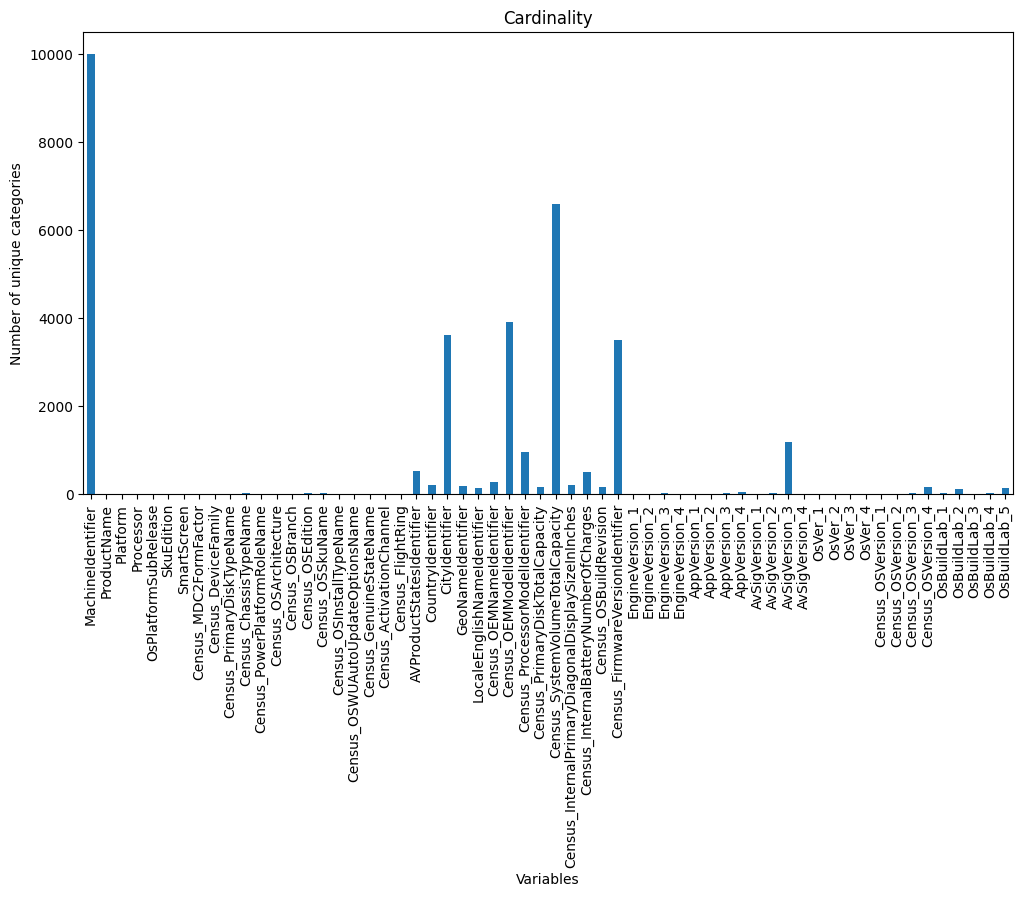

In [51]:
datos[cat_cols].nunique().plot.bar(figsize=(12,6))
plt.ylabel('Number of unique categories')
plt.xlabel('Variables')
plt.title('Cardinality')

In [52]:
datos[cat_cols].nunique()

MachineIdentifier                                    10000
ProductName                                              2
Platform                                                 4
Processor                                                2
OsPlatformSubRelease                                     9
SkuEdition                                               8
SmartScreen                                              8
Census_MDC2FormFactor                                   11
Census_DeviceFamily                                      2
Census_PrimaryDiskTypeName                               4
Census_ChassisTypeName                                  23
Census_PowerPlatformRoleName                             8
Census_OSArchitecture                                    2
Census_OSBranch                                         13
Census_OSEdition                                        16
Census_OSSkuName                                        15
Census_OSInstallTypeName                                

# ==================================================================================================================
# ===========================================> Eliminar valores mal balanceados <===================================
# ==================================================================================================================

drop_cols_min_big_cat_2 = 70
drop_cols_big_cat_2 = []

for col in cat_cols:
    if datos[col].value_counts(normalize=True, dropna=False).values[0] * 100 >= drop_cols_min_big_cat_2:
        drop_cols_big_cat_2.append(col) 

for col in drop_cols_big_cat_2:
    cat_cols.remove(col)

datos.drop(columns=drop_cols_big_cat_2, inplace=True)

drop_cols_big_cat_2

In [53]:
# ==================================================================================================================
# ===========================================> Ordenar variables <==================================================
# ==================================================================================================================

ordered_columns = cat_cols+numeric_cols
datos = datos[ordered_columns+['HasDetections']]

In [54]:
# ==================================================================================================================
# ===========================================> Codificar variables <================================================
# ==================================================================================================================

preprocessor = ColumnTransformer(
                    [('onehot', OneHotEncoder(handle_unknown='ignore'), cat_cols)],
                    remainder='passthrough')

In [55]:
# ==================================================================================================================
# ===========================================> Train Test Split <===================================================
# ==================================================================================================================

X_train, X_test, y_train, y_test = train_test_split(
                                        datos.drop(columns = 'HasDetections')[ordered_columns],
                                        datos['HasDetections'],
                                        random_state = 123)

print(y_train)


850680    0
731269    0
882661    0
656741    0
517676    1
14717     1
638567    0
842639    0
600688    0
573325    1
251135    1
103347    1
134376    1
97492     0
304233    0
124588    1
182744    1
799563    1
207782    0
148466    1
356017    1
617108    0
462634    0
306425    1
656907    1
784844    1
21152     0
733328    1
305227    1
367854    1
797405    1
34559     1
304697    1
217106    0
684605    0
790973    1
852896    0
746921    1
869110    0
544696    0
857993    1
837508    1
56151     0
288897    0
433362    0
87795     1
491426    0
644496    1
87673     1
288266    0
271259    0
15377     0
540624    0
485050    0
731438    0
869899    1
826685    1
408247    0
9249      0
637435    0
250036    0
659256    0
1255      1
830903    1
463485    0
506980    0
600306    0
37472     0
162775    1
886828    0
558246    1
666928    1
876142    1
774452    0
8732      1
66895     1
189615    1
451341    1
281170    1
755569    0
434322    1
825964    1
28681     1
6618

In [56]:
# ==================================================================================================================
# ===========================================> Modelo <=============================================================
# ==================================================================================================================

modelo = DecisionTreeClassifier(criterion= "entropy", max_depth=5, min_samples_leaf=3, random_state = 123)

modelo.fit(X_train_prep, y_train)

fig, ax = plt.subplots(figsize=(16, 6))

plot = plot_tree(
            decision_tree = modelo,
            feature_names = labels.tolist(),
            class_names   = 'HasDetections',
            filled        = True,
            impurity      = False,
            fontsize      = 7,
            ax            = ax)

NameError: name 'X_train_prep' is not defined

In [ ]:
predicciones = modelo.predict(X = X_test_prep)
pred_proba = modelo.predict_proba(X = X_test_prep)

In [ ]:
importancia_predictores = pd.DataFrame({
    "predictor": labels.tolist(),
    "importancia": modelo.feature_importances_
})

fig, ax = plt.subplots(figsize=(16, 6))

importancia_predictores.set_index("predictor").sort_values("importancia", ascending=True)[10:].plot(kind="barh", ax=ax)


In [ ]:
predicciones = modelo.predict(X = X_test_prep,)
pred_proba = modelo.predict_proba(X = X_test_prep)

data = confusion_matrix(y_test, predicciones)

print("Matriz de confusión")
plt.figure(figsize = (6,5))
sns.set(font_scale=1.4) #for label size
sns.heatmap(data, cmap="Blues", annot=True, annot_kws={"size": 12})


In [ ]:
print(f'Accuracy: {round(100*accuracy_score(y_test, predicciones),1)}%')

In [ ]:
print(classification_report(y_test, predicciones, digits=3, zero_division=True))

In [ ]:
fpr, tpr, _ = roc_curve(y_test, pred_proba[:,1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize = (6,5))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# ==================================================================================================================
# ===========================================> Procesar Unique Tipos Cat <==========================================
# ==================================================================================================================

#typed_min_unique = 10
#typed_cols = []

#for c in datos.columns:
#    if ((datos[c].nunique() / datos[c].count()) * 100) <= typed_min_unique:
#        typed_cols.append(c)
        
#for c in typed_cols:
#    datos[c] = datos[c].astype("category")

#print(typed_cols)

In [ ]:
# ==================================================================================================================
# ===========================================> Procesar Object Tipos Cat <==========================================
# ==================================================================================================================

#typed_cols = []
#cat_cols = []

#for c in datos.columns:
#    if datos[c].dtype == "object":
#        typed_cols.append(c)
#        cat_cols.append(c)
        
#for c in typed_cols:
#   datos[c] = datos[c].astype("category")

#datos["HasDetections"] = datos["HasDetections"].astype(int)

#print(typed_cols)

In [ ]:
#from sklearn.compose import ColumnTransformer


#from sklearn.model_selection import train_test_split
#from sklearn.ensemble import RandomForestClassifier
#from sklearn.metrics import accuracy_score


# Dividir los datos en características (X) y etiquetas (y)
#X = datostos.drop('HasDetections', axis=1)
#y = datos['HasDetections']

# Dividir los datos en conjuntos de entrenamiento y prueba
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrenar un modelo (por ejemplo, RandomForestClassifier)
#model = RandomForestClassifier()
#model.fit(X_train, y_train)


# Realizar predicciones en el conjunto de prueba
#y_pred = model.predict(X_test)

# Calcular la precisión del modelo
#accuracy = accuracy_score(y_test, y_pred)
#print(f"Precisión del modelo: {accuracy}")



cat_cols = datos.select_dtypes(include=['object', 'category']).columns.to_list()
numeric_cols = datos.select_dtypes(include=['float64', 'int64']).columns.to_list()

preprocessor = ColumnTransformer(
                    [('onehot', OneHotEncoder(handle_unknown='ignore'), cat_cols)],
                    remainder='passthrough')

X_train, X_test, y_train, y_test = train_test_split(
                                        datos.drop(columns = 'HasDetections'),
                                        datos['HasDetections'],
                                        random_state = 123)

X_train_prep = preprocessor.fit_transform(X_train)
X_test_prep  = preprocessor.transform(X_test)

encoded_cat = preprocessor.named_transformers_['onehot'].get_feature_names_out(cat_cols)
labels = np.concatenate([cat_cols, numeric_cols])

# Conversión a dataframe
X_train_prep = pd.DataFrame(X_train_prep.toarray(), columns=labels)
X_test_prep  = pd.DataFrame(X_test_prep.toarray(), columns=labels)
X_train_prep.info()

modelo = DecisionTreeClassifier(max_depth=3, random_state = 123)

modelo.fit(X_train_prep, y_train)

# Estructura del árbol creado
# ------------------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(16, 6))

print(f"Profundidad del árbol: {modelo.get_depth()}")
print(f"Número de nodos terminales: {modelo.get_n_leaves()}")

#plot = plot_tree(
#            decision_tree = modelo,
#            feature_names = labels.tolist(),
#            class_names   = 'HasDetections',
#            filled        = True,
#            impurity      = False,
#            fontsize      = 7,
#            ax            = ax)